In [11]:
import my_libs.network as my_net
import my_libs.preprocess as my_process
from run_evaluation import run_evaluation

In [12]:
setting = {
    'epoch': 2,
    'batch_size': 32,
    'use_gpu': True,
    'fixed_base_w': True
}

model = run_evaluation(my_process.Processing_11(), my_net.VGG(), setting)

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.936508       0.9625                    0.192835    0.0926208             149.84        
2           0.96371        0.97                      0.108717    0.0894009             298.485       
Preprocess             Processing_11
Model                            VGG
Elapsed time                 298.485
Validation accuracy             0.97
batch_size                        32
epoch                              2
fixed_base_w                    True
use_gpu                         True
dtype: object


In [27]:
import numpy as np
import pandas as pd
import os
from glob import glob
import chainer
from chainer.cuda import to_cpu
from chainer.datasets import TupleDataset, LabeledImageDataset, TransformDataset
from chainercv.transforms import resize, random_flip, random_crop, random_sized_crop, random_flip
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

In [39]:
def make_test_data(data_dir, preprocess):
    test_cats = glob(os.path.join(data_dir, 'cat/*.jpg'))
    test_dogs = glob(os.path.join(data_dir, 'dog/*.jpg'))

    train_label = {
        'cat': 1,
        'dog': 0}

    df = pd.DataFrame({
        'file_path': test_cats + test_dogs
    })
    df['label'] = df['file_path'].str.split('/', expand=True)[5]
    df['dataset'] = df['file_path'].str.split('/', expand=True)[4]
    df['target'] = df['label'].replace(train_label)
    
    # 下の行は新しいデータセットのときは消す
#     df = pd.concat([df.iloc[:56], df.iloc[57:579], df.iloc[650:]], axis=0)

    test = TupleDataset(df['file_path'].values, df['target'].values.astype('int32'))
    test = preprocess.transform(test)
    return test

In [40]:
data_dir = '../new_dataset/dataset/data/test_v2/'
test = make_test_data(data_dir, my_process.Processing_11())

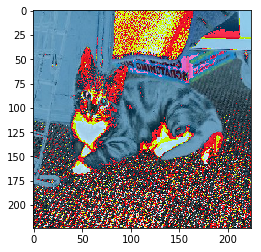

In [41]:
img = test[0][0].transpose(1, 2, 0)
plt.imshow(img)
plt.show()

In [17]:
predicted = []
true_label = []
for img, label in test:
    predict = model.predictor(np.array([img]))
    predicted.append(np.argmax(predict.data))
    true_label.append(label)

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


In [18]:
accuracy_score(true_label, predicted)

0.9234913793103449

In [20]:
n_tta = 10
predict_df = pd.DataFrame({
    'tta_score': np.zeros(len(test))
})
for i in range(n_tta):
    predicted = []
    true_label = []
    test = make_test_data(data_dir, my_process.Processing_11())
    for img, label in test:
        predict = model.predictor(np.array([img]))
        predicted.append(np.argmax(predict.data))
        true_label.append(label)
    predict_df['tta_score'] += np.array(predicted)

predicted = (predict_df['tta_score']/n_tta > 0.5).astype(int)
accuracy_score(true_label, predicted)

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


0.9558189655172413

In [21]:
n_tta = 30
predict_df = pd.DataFrame({
    'tta_score': np.zeros(len(test))
})
for i in range(n_tta):
    predicted = []
    true_label = []
    test = make_test_data(data_dir, my_process.Processing_11())
    for img, label in test:
        predict = model.predictor(np.array([img]))
        predicted.append(np.argmax(predict.data))
        true_label.append(label)
    predict_df['tta_score'] += np.array(predicted)

predicted = (predict_df['tta_score']/n_tta > 0.5).astype(int)
accuracy_score(true_label, predicted)

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


0.959051724137931

In [42]:
%%time
gpu_id = 0
model.to_gpu()

predicted = []
true_label = []
for img, label in test:
    img = np.array([img])
    img = model.xp.asarray(img)
    
    with chainer.using_config('train', False), chainer.using_config('enable_backprp', False):
        predict = model.predictor(img)
        
    predict = to_cpu(predict.data)
    predicted.append(np.argmax(predict))
    true_label.append(label)

model.to_cpu()
print(accuracy_score(true_label, predicted))

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


0.958
CPU times: user 26.8 s, sys: 7.16 s, total: 33.9 s
Wall time: 33.9 s


In [33]:
%%time

model.to_cpu()

predicted = []
true_label = []
for img, label in test:
    predict = model.predictor(np.array([img]))
    predicted.append(np.argmax(predict.data))
    true_label.append(label)

print(accuracy_score(true_label, predicted))

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


0.9224137931034483
CPU times: user 1h 2min 29s, sys: 32min 15s, total: 1h 34min 44s
Wall time: 7min 55s
